# In-scope Prediction 

Using the CLINC150 dataset in a semi-supervised method, by masking a portion of the labeled data as unlabeled to analyse how well the GAN-BERT does in-scope prediction given unlabeled data.

Each of the notebooks in this experiment contain the code, statistics, loss & accuracy curves for different variations of splitting the labeled & unlabeled examples that the GAN-BERT model is training on.

The first section, namely, 'Base Model/10_90 split' has all the code that is run on the dataset in the proportion of 10-90, containing 10% labeled examples and 90% unlabeled examples.
In the subsequent notebooks, the same process is repeated for different variations:
- 20_80
- 40_60
- 60_40
- 80_20
- 90_10

# Base Model/ 10_90 split

## Importing necessary packages

In [1]:
!pip install transformers==4.3.2
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 8.9 MB/s 
     |████████████████████████████████| 3.3 MB 51.1 MB/s 
     |████████████████████████████████| 880 kB 66.2 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=3a7e7d938f196a224af9d06d5ce79b2ace64af8cf73a1ea181c8228c2e8a9232
  Stored in directory: /root/.cache/pip/wheels/82/ab/9b/c15899bf659ba74f623ac776e861cf2eb8608c1825ddec66a4
Successfully built sacremoses
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 452 kB 5.9 MB/s 
     |████████████████████████████████| 182 kB 70.4 MB/s 
     |████████████████████████████████| 212 kB 70.8 MB/s 
     |████████████████████████████████| 132 kB 62.9 MB/s 
     |████████████████████████████████| 127 kB 82.0 MB/s 
  Attempting uninstall: urllib3
    Found e

In [2]:
import json
from sklearn.model_selection import train_test_split
import torch
import io
import torch.nn.functional as F
import random
import numpy as np
import time
import math
import datetime
import torch.nn as nn
import pandas as pd

from transformers import *
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from datasets import load_dataset

## Utility functions

In [3]:
# Set random values
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed_val)

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [5]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

## Data Processing 

'data_full.json' is the file from the CLINC150 repository that contains the full variant of the dataset.
It consists of 15,000 training examples, with 3,000 validation samples and 4,500 test samples.

We decided to use this variant since the small or imbalanced data would not give us accurate results and since we were performing in-scope prediction in this case, the OOS+ variant would not be suitable.

Structure:

The json file has keys which represent each set. Each set is a list of lists where each list represents one example containing a [sentence, intent].

For example, ['what expression would i use to say i love you if i were an italian', 'translate']

In [7]:
with open('data_full.json') as json_file:
  data = json.load(json_file)
  json_file.close()

In [8]:
print(data.keys())
print(type(data['train']))
print(type(data['train'][0]))
print(data['train'][0])

dict_keys(['oos_val', 'val', 'train', 'oos_test', 'test', 'oos_train'])
<class 'list'>
<class 'list'>
['what expression would i use to say i love you if i were an italian', 'translate']


In [9]:
intent_set = ['UNK_UNK'] # set of all intents
for sent in data['train']:
  if sent[1] not in intent_set:
    intent_set.append(sent[1])

print(len(intent_set))
print(intent_set[:3])

151
['UNK_UNK', 'translate', 'transfer']


We have added a label for the unlabeled intent since the data does not inherently contain any unlabeled samples. Hence the total number of classes is 151.

In [10]:
intent_map = {}
for (i, label) in enumerate(intent_set):
  intent_map[label] = i

In [11]:
def split_labeled(intent_df, labeled_prop,unlabeled_prop):
  test_size = unlabeled_prop/ (labeled_prop + unlabeled_prop)
  df_labeled, df_unlabeled = train_test_split(intent_df, stratify = intent_df['intent'], test_size = test_size, random_state = 42)

  df_labeled = df_labeled.reset_index(drop=True)
  df_unlabeled = df_unlabeled.reset_index(drop=True)
  print(df_labeled.head())
  print(df_unlabeled.head())
  print(df_labeled.shape)
  print(df_unlabeled.shape)

  #add into 2 lists - labeled_examples & unlabeled_examples
  labeled_examples = []
  unlabeled_examples = []
  for i in range(len(df_labeled)):
    labeled_examples.append((df_labeled.loc[i, 'text'], df_labeled.loc[i, 'intent']))
  
  print(labeled_examples[:3])

  for i in range(len(df_unlabeled)):
    unlabeled_examples.append((df_unlabeled.loc[i, 'text'], 'UNK_UNK'))

  print(unlabeled_examples[:3])

  return labeled_examples, unlabeled_examples


In [12]:
intent_train_df = pd.DataFrame(data['train'], columns = ['text', 'intent'])
intent_train_df.head()

,text,intent
0,what expression would i use to say i love you ...,translate
1,can you tell me how to say 'i do not speak muc...,translate
2,"what is the equivalent of, 'life is good' in f...",translate
3,"tell me how to say, 'it is a beautiful morning...",translate
4,"if i were mongolian, how would i say that i am...",translate


In this first variation, the split is labeled = 10, unlabeled = 90

In [13]:
#1st Variation
labeled_examples, unlabeled_examples = split_labeled(intent_train_df, labeled_prop=10,unlabeled_prop=90)

                                                text              intent
0                           how is the tire pressure       tire_pressure
1  are there any international transaction fees a...  international_fees
2      does my car have enough gas to get to detroit                 gas
3  i want to find a roundtrip flight from philade...         book_flight
4               tell me my car's tire pressure level       tire_pressure
                                    text         intent
0        disconnect from my phone for me    sync_device
1         tell me a few facts about cats       fun_fact
2  tell me your guess of what my name is      user_name
3     what did i put on my shopping list  shopping_list
4        when am i due for a tire change    tire_change
(1500, 2)
(13500, 2)
[('how is the tire pressure', 'tire_pressure'), ('are there any international transaction fees associated with my visa card', 'international_fees'), ('does my car have enough gas to get to detroit', 'gas')

In [14]:
# validation 
val_examples = []
for sent in data['val']:
  val_examples.append((sent[0], sent[1]))

# test
test_examples = []
for sent in data['test']:
  test_examples.append((sent[0], sent[1]))

Tokenization / Dataloader

In [15]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True) 

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [16]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set 

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [17]:
# tokenizer + dataloader 

def dataloader(ip_examples, label_masks, intent_map, do_shuffle, balance):
  # applying balance
  examples = []

  # Count the percentage of labeled examples  
  num_labeled_examples = 0 
  for label_mask in label_masks:
    if label_mask: 
      num_labeled_examples += 1
  label_mask_rate = num_labeled_examples/len(ip_examples)

  # if required it applies the balance
  for index, ex in enumerate(ip_examples): 
    if label_mask_rate == 1 or not balance: #if all labeled or balancing is not needed
      examples.append((ex, label_masks[index]))
    else:
      # IT SIMULATE A LABELED EXAMPLE
      if label_masks[index]:
        balance = int(1/label_mask_rate)
        balance = int(math.log(balance,2))
        if balance < 1:
          balance = 1
        for b in range(0, int(balance)):
          examples.append((ex, label_masks[index]))
      else:
        examples.append((ex, label_masks[index]))


  input_ids = []
  input_mask_array = []
  label_mask_array = []
  label_id_array = []

  # tokenization
  for (text, label_mask) in examples:
    encoded_sent = tokenizer.encode(text[0], add_special_tokens=True, max_length=40, padding="max_length", truncation=True)
    input_ids.append(encoded_sent)
    label_id_array.append(intent_map[text[1]])
    label_mask_array.append(label_mask)

  # Attention to token (to ignore padded input wordpieces)
  for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]                          
    input_mask_array.append(att_mask)

  # Convertion to Tensor
  input_ids = torch.tensor(input_ids) 
  input_mask_array = torch.tensor(input_mask_array)
  label_id_array = torch.tensor(label_id_array, dtype=torch.long)
  label_mask_array = torch.tensor(label_mask_array)

  # Building the TensorDataset
  dataset = TensorDataset(input_ids, input_mask_array, label_id_array, label_mask_array)

  if do_shuffle:
    sampler = RandomSampler
  else:
    sampler = SequentialSampler

  # Building the DataLoader
  return DataLoader(dataset, sampler = sampler(dataset), batch_size = 64) 


The sentence with the max length = 33, hence for each sentence in a batch, padding is done to make them all of length 40.

In [18]:

# label masks - True for labeled, False for unlabeled
lab_label_masks = np.ones(len(labeled_examples), dtype=bool)
unlab_label_masks = np.zeros(len(unlabeled_examples), dtype=bool)
train_label_masks = np.concatenate([lab_label_masks,unlab_label_masks])

# train examples - labeled + unlabeled
train_examples = labeled_examples + unlabeled_examples

# train dataloader 
train_dataloader = dataloader(train_examples, train_label_masks, intent_map, do_shuffle = True, balance = True)

#val dataloader
val_label_masks = np.ones(len(val_examples), dtype=bool)
val_dataloader = dataloader(val_examples, val_label_masks, intent_map, do_shuffle = False, balance = False)

#test dataloader
test_label_masks = np.ones(len(test_examples), dtype=bool)
test_dataloader = dataloader(test_examples, test_label_masks, intent_map, do_shuffle = False, balance = False)


<ipython-input-17-7b370dd84a6f>:56: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  label_mask_array = torch.tensor(label_mask_array)


## Building the Model

In [19]:
# BERT
transformer =  BertModel.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [20]:
#Generator

class Generator(nn.Module):
    def __init__(self, noise_size, output_size, hidden_sizes, dropout_rate):
        super(Generator, self).__init__()
        layers = []
        hidden_sizes = [noise_size] + hidden_sizes
        for i in range(len(hidden_sizes)-1):
            layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(dropout_rate)])

        layers.append(nn.Linear(hidden_sizes[-1],output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, noise):
        output_rep = self.layers(noise)
        return output_rep

In [21]:
# Discriminator

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_labels, dropout_rate):
        super(Discriminator, self).__init__()
        self.input_dropout = nn.Dropout(p=dropout_rate)
        layers = []
        hidden_sizes = [input_size] + hidden_sizes
        for i in range(len(hidden_sizes)-1):
            layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(dropout_rate)])

        self.layers = nn.Sequential(*layers) #per il flatten
        self.logit = nn.Linear(hidden_sizes[-1],num_labels+1) # +1 for the probability of this sample being fake/real.
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input_rep):
        input_rep = self.input_dropout(input_rep)
        last_rep = self.layers(input_rep)
        logits = self.logit(last_rep)
        probs = self.softmax(logits)
        return last_rep, logits, probs

In [22]:
noise_size = 100
config = BertConfig.from_pretrained("bert-base-uncased")
hidden_size = config.hidden_size # BERT outputs a 768 embedding vector
num_hidden_layers_gen = 1
hidden_levels_gen = [hidden_size for i in range(0, num_hidden_layers_gen)]
num_hidden_layers_disc = 1
hidden_levels_disc = [hidden_size for i in range(0, num_hidden_layers_disc)]

# dropout to be applied to discriminator's input vectors
out_dropout_rate = 0.2

num_labels = len(intent_map)

generator = Generator(noise_size=noise_size, #100
                      output_size=hidden_size, #768
                      hidden_sizes=hidden_levels_gen, #[768] 
                      dropout_rate=out_dropout_rate) #0.2

discriminator = Discriminator(input_size=hidden_size, #768
                              hidden_sizes=hidden_levels_disc, #[768]
                              num_labels=num_labels, #151 - no oos
                              dropout_rate=out_dropout_rate) #0.2


In [23]:
# input dim - 100x768
# output dim - 768x768
generator

Generator(
  (layers): Sequential(
    (0): Linear(in_features=100, out_features=768, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=768, out_features=768, bias=True)
  )
)

In [24]:
# input dim - 768x768
# output dim - 768x152
discriminator  

Discriminator(
  (input_dropout): Dropout(p=0.2, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=768, out_features=768, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.2, inplace=False)
  )
  (logit): Linear(in_features=768, out_features=152, bias=True)
  (softmax): Softmax(dim=-1)
)

In [25]:
# input dim - 30522x768
# output dim - 768x768
transformer 

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [26]:
multi_gpu = True
if torch.cuda.is_available():    
  generator.cuda()
  discriminator.cuda()
  transformer.cuda()
  if multi_gpu:
    transformer = torch.nn.DataParallel(transformer)

In [27]:
#models parameters
transformer_vars = [i for i in transformer.parameters()]
d_vars = transformer_vars + [v for v in discriminator.parameters()]
g_vars = [v for v in generator.parameters()]

learning_rate_generator = 5e-5
learning_rate_discriminator = 5e-5

#optimizer
dis_optimizer = torch.optim.AdamW(d_vars, lr=learning_rate_discriminator)
gen_optimizer = torch.optim.AdamW(g_vars, lr=learning_rate_generator) 

In [28]:
#scheduler
apply_scheduler = False
batch_size = 64
num_epochs = 10
warmup_proportion = 0.1

if apply_scheduler:
  num_train_examples = len(train_examples)
  num_train_steps = int(num_train_examples / batch_size * num_epochs)
  num_warmup_steps = int(num_train_steps * warmup_proportion)

  scheduler_d = get_constant_schedule_with_warmup(dis_optimizer, 
                                           num_warmup_steps = num_warmup_steps)
  scheduler_g = get_constant_schedule_with_warmup(gen_optimizer, 
                                           num_warmup_steps = num_warmup_steps)

## Training & Evaluation

In [29]:
# training & validation
best_valid_loss = float('inf')
model = '10_90'
training_stats = []
train_gen_loss_history = []
train_disc_loss_history = []
val_loss_history = []
val_accuracies = []

for epoch in range(num_epochs):
  print("")
  print('======== Epoch {:} / {:} ========'.format(epoch + 1, num_epochs))
  print('Training...')

  t0 = time.time()

  # loss for each epoch
  tr_g_loss = 0
  tr_d_loss = 0

  transformer.train()
  generator.train()
  discriminator.train()

  for idx, batch in enumerate(train_dataloader):

    # Progress update every print_each_n_step batches.
    if idx % 40 == 0 and not idx == 0:
        # Calculate elapsed time in minutes.
        elapsed = format_time(time.time() - t0)
        
        # Report progress.
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(idx, len(train_dataloader), elapsed))

    b_input_ids = batch[0].to(device) #tensor of input ids of that batch
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    b_label_mask = batch[3].to(device)

    real_batch_size = b_input_ids.shape[0] 
    # print('real_batch_size: ', real_batch_size) #size of each batch = 64

    model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
    hidden_states = model_outputs[-1]
    # print('hidden states', hidden_states.size()) #64x768 - 768 per sentence in batch

    noise = torch.zeros(real_batch_size, noise_size, device=device).uniform_(0, 1)
    # print('noise', noise.size()) # 64x100 - 100 per sentence in batch 
    gen_rep = generator(noise)
    # print('gen output', gen_rep.size()) #64x768 
    # both transformer + gen output are 768 size

    disciminator_input = torch.cat([hidden_states, gen_rep], dim=0)
    # print('disc input', disciminator_input.size()) # 64x768
    features, logits, probs = discriminator(disciminator_input)

    # print('disc output', features.size()) #64x768
    # print('2: ', logits.size()) #64x152
    # print('3: ', probs.size()) #64x152

    features_list = torch.split(features, real_batch_size) #split 64x768 into 32,32
    D_real_features = features_list[0]
    D_fake_features = features_list[1] 

    logits_list = torch.split(logits, real_batch_size)
    D_real_logits = logits_list[0]
    D_fake_logits = logits_list[1]  

    probs_list = torch.split(probs, real_batch_size)
    D_real_probs = probs_list[0]
    D_fake_probs = probs_list[1]

    #loss

    #gen loss
    g_loss_d = -1 * torch.mean(torch.log(1 - D_fake_probs[:,-1] + 1e-8))
    g_feat_reg = torch.mean(torch.pow(torch.mean(D_real_features, dim=0) - torch.mean(D_fake_features, dim=0), 2))
    g_loss = g_loss_d + g_feat_reg

    #disc loss
    logits = D_real_logits[:,0:-1]
    log_probs = F.log_softmax(logits, dim=-1)

    label2one_hot = torch.nn.functional.one_hot(b_labels, 151)
    per_example_loss = -torch.sum(label2one_hot * log_probs, dim=-1)
    per_example_loss = torch.masked_select(per_example_loss, b_label_mask.to(device))
    labeled_example_count = per_example_loss.type(torch.float32).numel()

    if labeled_example_count == 0:
      D_L_Supervised = 0
    else:
      D_L_Supervised = torch.div(torch.sum(per_example_loss.to(device)), labeled_example_count)

    D_L_unsupervised1U = -1 * torch.mean(torch.log(1 - D_real_probs[:, -1] + 1e-8))
    D_L_unsupervised2U = -1 * torch.mean(torch.log(D_fake_probs[:, -1] + 1e-8))
    d_loss = D_L_Supervised + D_L_unsupervised1U + D_L_unsupervised2U

    #optimization
    gen_optimizer.zero_grad()
    dis_optimizer.zero_grad()

    g_loss.backward(retain_graph=True)
    d_loss.backward()

    gen_optimizer.step()
    dis_optimizer.step()

    tr_g_loss += g_loss.item()
    tr_d_loss += d_loss.item()

    if apply_scheduler:
      scheduler_d.step()
      scheduler_g.step()

  avg_train_loss_g = tr_g_loss / len(train_dataloader)
  avg_train_loss_d = tr_d_loss / len(train_dataloader)
  
  training_time = format_time(time.time() - t0)

  print("")
  print("  Average training loss generator: {0:.3f}".format(avg_train_loss_g))
  print("  Average training loss discriminator: {0:.3f}".format(avg_train_loss_d))
  print("  Training epoch took: {:}".format(training_time))
  train_gen_loss_history.append(avg_train_loss_g)
  train_disc_loss_history.append(avg_train_loss_d)

  #EVALUATION

  print("")
  print("Running validation...")

  t0 = time.time()

  transformer.eval() 
  discriminator.eval()
  generator.eval()

  total_val_accuracy = 0
   
  total_val_loss = 0
  nb_test_steps = 0

  all_preds = []
  all_labels_ids = []

  #loss
  nll_loss = torch.nn.CrossEntropyLoss(ignore_index=-1)

  for idx, batch in enumerate(val_dataloader):
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad():        
        model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
        hidden_states = model_outputs[-1]
        _, logits, probs = discriminator(hidden_states)
        ###log_probs = F.log_softmax(probs[:,1:], dim=-1)
        filtered_logits = logits[:,0:-1]
        # Accumulate the test loss.
        total_val_loss += nll_loss(filtered_logits, b_labels)

    # Accumulate the predictions and the input labels
    _, preds = torch.max(filtered_logits, 1)
    all_preds += preds.detach().cpu()
    all_labels_ids += b_labels.detach().cpu()


  # Report the final accuracy for this validation run.
  all_preds = torch.stack(all_preds).numpy()
  all_labels_ids = torch.stack(all_labels_ids).numpy()
  val_accuracy = np.sum(all_preds == all_labels_ids) / len(all_preds)
  print("  Accuracy: {0:.3f}".format(val_accuracy))
  val_accuracies.append(val_accuracy)

  # Calculate the average loss over all of the batches.
  avg_val_loss = total_val_loss / len(val_dataloader)
  avg_val_loss = avg_val_loss.item()
  if avg_val_loss < best_valid_loss:
    best_valid_loss = avg_val_loss
    torch.save(transformer.state_dict(), 'model_'+model+'.pt')
    print("Saving...", epoch)
  test_time = format_time(time.time() - t0)
    
  print("  Val Loss: {0:.3f}".format(avg_val_loss))
  print("  Val took: {:}".format(test_time))
  val_loss_history.append(avg_val_loss)

  training_stats.append(
        {
            'epoch': epoch + 1,
            'Training Loss generator': avg_train_loss_g,
            'Training Loss discriminator': avg_train_loss_d,
            'Val Loss': avg_val_loss,
            'Val Accur.': val_accuracy,
            'Training Time': training_time,
            'Val Time': test_time
        }
    )




======== Epoch 1 / 10 ========
Training...
  Batch    40  of    282.    Elapsed: 0:00:26.
  Batch    80  of    282.    Elapsed: 0:00:50.
  Batch   120  of    282.    Elapsed: 0:01:14.
  Batch   160  of    282.    Elapsed: 0:01:38.
  Batch   200  of    282.    Elapsed: 0:02:03.
  Batch   240  of    282.    Elapsed: 0:02:28.
  Batch   280  of    282.    Elapsed: 0:02:53.

  Average training loss generator: 0.675
  Average training loss discriminator: 5.558
  Training epoch took: 0:02:54

Running validation...
  Accuracy: 0.390
Saving... 0
  Val Loss: 3.457
  Val took: 0:00:07

======== Epoch 2 / 10 ========
Training...
  Batch    40  of    282.    Elapsed: 0:00:25.
  Batch    80  of    282.    Elapsed: 0:00:50.
  Batch   120  of    282.    Elapsed: 0:01:15.
  Batch   160  of    282.    Elapsed: 0:01:40.
  Batch   200  of    282.    Elapsed: 0:02:05.
  Batch   240  of    282.    Elapsed: 0:02:30.
  Batch   280  of    282.    Elapsed: 0:02:55.

  Average training loss generator: 0.760
  A

## Testing

In [32]:
transformer.load_state_dict(torch.load('/content/model_10_90.pt'))
transformer

DataParallel(
  (module): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [39]:
# testing

print("")
print("Running test...")
transformer.load_state_dict(torch.load('model_10_90.pt'))

t0 = time.time()

transformer.eval() 
discriminator.eval()
generator.eval()

total_test_accuracy = 0
  
total_test_loss = 0
nb_test_steps = 0

all_preds = []
all_labels_ids = []

#loss
nll_loss = torch.nn.CrossEntropyLoss(ignore_index=-1)

for idx, batch in enumerate(test_dataloader):
  b_input_ids = batch[0].to(device)
  b_input_mask = batch[1].to(device)
  b_labels = batch[2].to(device)

  with torch.no_grad():        
      model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
      hidden_states = model_outputs[-1]
      _, logits, probs = discriminator(hidden_states)
      filtered_logits = logits[:,0:-1]
      # Accumulate the test loss.
      total_test_loss += nll_loss(filtered_logits, b_labels)

  # Accumulate the predictions and the input labels
  _, preds = torch.max(filtered_logits, 1)
  all_preds += preds.detach().cpu()
  all_labels_ids += b_labels.detach().cpu()


# Report the final accuracy for this validation run.
all_preds = torch.stack(all_preds).numpy()
all_labels_ids = torch.stack(all_labels_ids).numpy()
test_accuracy = np.sum(all_preds == all_labels_ids) / len(all_preds)
print("  Accuracy: {0:.3f}".format(test_accuracy))

# Calculate the average loss over all of the batches.
avg_test_loss = total_test_loss / len(test_dataloader)
avg_test_loss = avg_test_loss.item()

test_time = format_time(time.time() - t0)
  
print("  Test Loss: {0:.3f}".format(avg_test_loss))
print("  Test took: {:}".format(test_time))


Running test...
  Accuracy: 0.889
  Test Loss: 0.614
  Test took: 0:00:08


The first split gets a pretty high accuracy of 88.9%

### Loss & Accuracy curves

In [34]:
import matplotlib.pyplot as plt

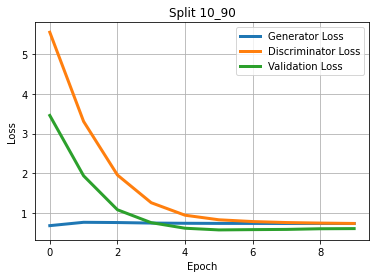

In [40]:
plt.plot(range(10),train_gen_loss_history,'-',linewidth=3,label='Generator Loss')
plt.plot(range(10),train_disc_loss_history,'-',linewidth=3,label='Discriminator Loss')
plt.plot(range(10),val_loss_history,'-',linewidth=3,label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.title("Split 10_90")
plt.legend()

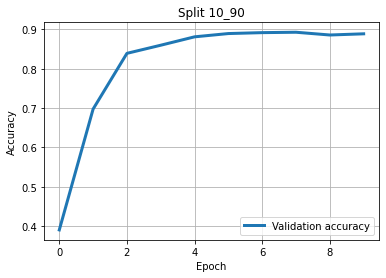

In [41]:
plt.plot(range(10), val_accuracies,'-', linewidth=3, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.title("Split 10_90")
plt.legend()

### Statistics

In [37]:

stats = []
stats.append(
    {
    'gen train loss history': train_gen_loss_history ,
    'disc train loss history': train_disc_loss_history,
    'val loss': val_loss_history,
    'val accuracy': val_accuracies,
    'test loss': avg_test_loss,
    'test accuracy': test_accuracy
    }
)

with open('stats_'+model+'best'+'.txt','w') as f_out:
  f_out.write(str(stats[0]))
  print('Done')
  f_out.close()


Done
